<b>Battleship</b> is a classic two person game, originally played with pen and paper.

On a grid (typically 10 x 10), players 'hide' ships of mixed length; horizontally or
vertically (not diagonally) without any overlaps. The exact types and number of ships
varies by rule, but for this posting, I'm using ships of lengths: 5, 4, 3, 3, 2 (which results
in 17 possible targets out of the total of 100 squares).

First, we try to make gameboard with enumerated squares.

In [1]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

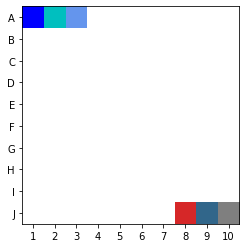

In [2]:
# create board image (initially completely white)
nrows, ncols = 10, 10
board = np.ones([nrows, ncols, 3])

# color some squares 
# there is an example about named colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
board[0, 0] = (0, 0, 1)  # rgb color
board[0, 1] = colors.to_rgb('c')  # base color
board[0, 2] = colors.to_rgb('cornflowerblue')  # css color
board[9, 7] = colors.to_rgb('tab:red')  # tabeau palette color
board[9, 8] = colors.to_rgb('xkcd:ugly blue')  # xkcd color
board[9, 9] = 0.5  # gray level color

# create labels
row_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
col_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# create figure and axes, plot image
fig, ax = plt.subplots()
ax.imshow(board, origin='upper')

# show all ticks
ax.set_xticks(np.arange(ncols))
ax.set_yticks(np.arange(nrows))

# set custom labels
ax.set_xticklabels(row_labels)
ax.set_yticklabels(col_labels)

# set bounds explicitly (not setting it clips top and bottom of the image)
ax.set_xbound(-0.5, 9.5)
ax.set_ybound(-0.5, 9.5)

Next, we add function to select individual squares with hidden ships inside them.

In [3]:
# clear board
board = np.ones([nrows, ncols, 3])

In [4]:
# position should be a string or list of strings in [A-J][1-10] format
def hide_ship(*locations):
    for location in locations:
        row = ord(location[0]) - ord('A')
        col = int(location[1:]) - 1
        board[row, col] = colors.to_rgb('royalblue')

In [5]:
# also create function to unhide a ship
def unhide_ship(*locations):
    for location in locations:
        row = ord(location[0]) - ord('A')
        col = int(location[1:]) - 1
        board[row, col] = 1

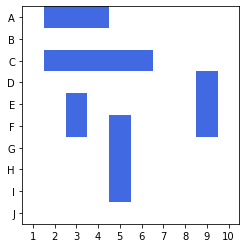

In [6]:
# test hide_ship function
hide_ship('A2', 'A3', 'A4')
hide_ship('C2', 'C3', 'C4', 'C5', 'C6')
hide_ship('E3', 'F3')
hide_ship('F5', 'G5', 'H5', 'I5')
hide_ship('D9', 'E9', 'F9')

# show gameboard on existing axes
ax.imshow(board, origin='upper')

# we are reusing created figure, so we need to type 'fig' instead of 'plt.show()'
# for more info, see: https://stackoverflow.com/questions/39338053/jupyter-replot-in-different-cell
fig

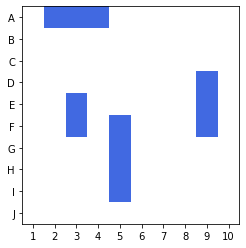

In [7]:
# test unhide_ship function
unhide_ship('C2', 'C3', 'C4', 'C5', 'C6')
ax.imshow(board, origin='upper')
fig

We add grid to gameboard and remove tick marks to make it easier to read.

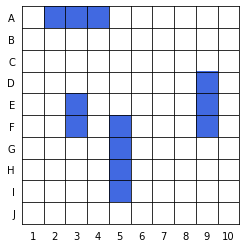

In [8]:
# set up minor ticks
ax.minorticks_on()
ax.set_xticks(np.arange(ncols) + 0.5, minor=True)
ax.set_yticks(np.arange(nrows) + 0.5, minor=True)

# turn off the display of all ticks
ax.tick_params(which='both',  # options for both major and minor ticks
                top=False,  # turn off top ticks
                left=False,  # turn off left ticks
                right=False,  # turn off right ticks
                bottom=False)  # turn off bottom ticks)

# reset bounds (seems like setting ticks messes up bounds)
ax.set_xbound(-0.5, 9.5)
ax.set_ybound(-0.5, 9.5)

# show grid on minor ticks
ax.grid(which='minor', linestyle='-', color='black')

fig

We’ll start with a description of the simplified method of play:

After each player has hidden his fleet, players alternate taking
shots at each other by specifying the coordinates of the target
location. After each shot, the opponent responds with either a
call <font color='red'>HIT!</font> or <font color='gray'>MISS!</font> indicating whether the target coordinates
have hit part of a boat, or open water.

In these diagrams, misses are depicted by grey crosses and hits
by red squares with grey crosses.

The first player to sink his opponent’s fleet (hitting every location
covered with part of a boat) wins the game.

Our next functions should be about choosing target location and getting hit or miss feedback.

In [9]:
# updates gameboard and returns True if boat was hit
def shoot(location):
    row = ord(location[0]) - ord('A')
    col = int(location[1:]) - 1
    
    # draw grey hit marker
    ax.plot(col, row, marker='X', markersize=15, color='darkgray')
    
    # check if boat's at current location and change the color of square to red if so
    if (board[row, col] == colors.to_rgb('royalblue')).all():
        board[row, col] = colors.to_rgb('red')
        print("HIT!")
        return True
    else:
        print("MISS!")
        return False

HIT!


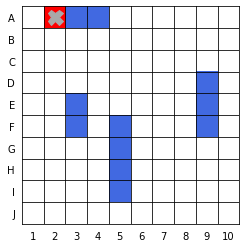

In [10]:
# test shoot function
shoot('A2')
ax.imshow(board, origin='upper')
fig

MISS!


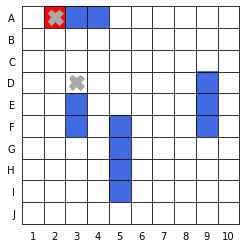

In [11]:
# test shoot function
shoot('D3')
ax.imshow(board, origin='upper')
fig

HIT!


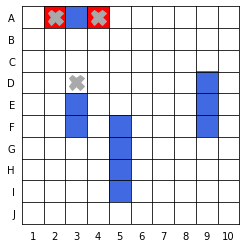

In [12]:
# test shoot function
shoot('A4')
ax.imshow(board, origin='upper')
fig

At this point we've implemented basic functionality so we're ready to start game simulations. However, these aren't full game rules. The official rules also state that you should let your opponent know if they've successfully SUNK any ship. We're going to implement that later. For now, we'll wrap everything in Gameboard class and implement some more helpful methods along the way.

In [13]:
class Gameboard:
    # static variables (they aren't intended to change)
    nrows, ncols = 10, 10
    row_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    col_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    boat_color = colors.to_rgb('royalblue')
    hit_color = colors.to_rgb('red')
    
    def __init__(self):
        # create board image (initially completely white)
        self.board = np.ones([Gameboard.nrows, Gameboard.ncols, 3])

        # create figure and axes
        self.fig, self.ax = plt.subplots()

        # show all ticks
        self.ax.set_xticks(np.arange(Gameboard.ncols))
        self.ax.set_yticks(np.arange(Gameboard.nrows))

        # set custom labels
        self.ax.set_xticklabels(Gameboard.row_labels)
        self.ax.set_yticklabels(Gameboard.col_labels)
        
        # set up minor ticks
        self.ax.minorticks_on()
        self.ax.set_xticks(np.arange(Gameboard.ncols) + 0.5, minor=True)
        self.ax.set_yticks(np.arange(Gameboard.nrows) + 0.5, minor=True)

        # turn off the display of all ticks
        self.ax.tick_params(which='both', top=False, left=False, right=False, bottom=False)

        # show grid on minor ticks
        self.ax.grid(which='minor', linestyle='-', color='black')

        # set bounds
        self.ax.set_xbound(-0.5, 9.5)
        self.ax.set_ybound(-0.5, 9.5)
        
        print('done')
        
    # position should be a string or list of strings in [A-J][1-10] format
    def hide_ship(self, *locations):
        for location in locations:
            row = ord(location[0]) - ord('A')
            col = int(location[1:]) - 1
            self.board[row, col] = Gameboard.boat_color
            
    def unhide_ship(self, *locations):
        for location in locations:
            row = ord(location[0]) - ord('A')
            col = int(location[1:]) - 1
            # change square color to white
            self.board[row, col] = 1
    
    def clear(self):
        self.board = np.ones([Gameboard.nrows, Gameboard.ncols, 3])
        for line in self.ax.get_lines():
            line.set_marker(None)
        
    # updates gameboard and returns True if boat was hit
    def shoot(self, location):
        row = ord(location[0]) - ord('A')
        col = int(location[1:]) - 1

        # draw grey hit marker
        self.ax.plot(col, row, marker='X', markersize=15, color='darkgray')

        # check if boat's at current location and change the color of square to red if so
        if (self.board[row, col] == Gameboard.boat_color).all():
            self.board[row, col] = Gameboard.hit_color
            return True
        else:
            return False
        
    # returns matplotlib figure
    def get_figure(self):
        self.update()
        return self.fig
    
    # returns matplotlib axes
    def get_axes(self):
        self.update()
        return self.ax
    
    # applies changes made to board array
    def update(self):
        self.ax.imshow(self.board, origin='upper')

Next, we create board object from Gameboard class and test it.

In [14]:
%%capture

# create Gameboard object
board = Gameboard()

# hide two ships
board.hide_ship('B4', 'B5', 'B6')
board.hide_ship('I10', 'H10', 'G10', 'F10', 'E10')

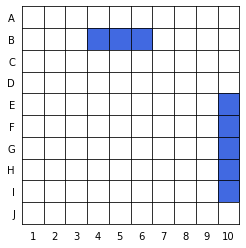

In [15]:
board.get_figure()

In [16]:
board.shoot('C4')

False

In [17]:
board.shoot('F10')

True

In [18]:
board.shoot('F9')

False

In [19]:
board.shoot('E10')

True

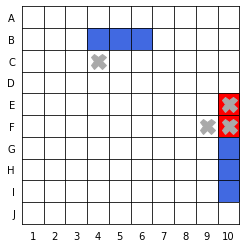

In [20]:
board.get_figure()

As we see, everything works as expected. There's just that methods don't check if, for example, location is in bounds, or if shoot method is called twice on the same location. For now, these things are on API user to take care of.